Analyzing Odds Data

In the last notebook, we obtained historical odds data from oddsshark, and then augmented our game level data to include the implied probabilities, and over/under lines.
We saved that data to a file called 'df_bp3.csv'
In this notebook, we will do some initial exploration of that odds data, and compare the quality of our first model predictions to the implied probabilities given by the oddsmakers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)


In [2]:
df=pd.read_csv('df_bp3.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205521 entries, 0 to 205520
Columns: 199 entries, date to over_under_result
dtypes: float64(90), int64(12), object(97)
memory usage: 312.0+ MB


In [4]:
# checks to see if '0-probability' occurs in correct spots

pd.crosstab(df.implied_prob_h>0, df.season)

season,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
implied_prob_h,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1110,1117,1114,1249,1237,1228,1233,1244,1241,1249,1237,1232,1234,1880,1864,1247,1247,1016,1118,1234,1229,1238,1233,1231,1228,1234,1236,1231,1229,1234,1236,1233,1226,1223,1228,1238,1239,1223,1231,1236,1244,1224,1238,1242,1230,1242,1243,1237,1240,1238,1239,1239,1240,1237,1234,1239,1235,1235,1238,1236,1430,1621,1619,1626,1623,1615,1620,1625,1946,1944,1938,1859,1943,1945,1934,1939,2103,2102,2099,2105,1394,2107,2109,2105,2103,2103,2105,2100,2106,2105,2104,2106,2269,1600,2017,2267,2266,2432,2428,2429,2429,2426,2430,2428,2431,2429,2431,2428,2430,2430,2429,2430,2431,2430,2429,2428,2430,2431,0,0,0,0
True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2429,898,2426,2430


In [5]:
df_odds = df[df.season>=2019]

In [6]:
df_odds.sample(5)

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result
198889,20190726,0,Fri,CLE,AL,103,KCA,AL,105,8,3,54,N,NaN,NaN,NaN,KAN06,26609.0,176.0,002003111,000010002,36.0,13.0,2.0,1.0,1.0,8.0,0.0,1.0,1.0,5.0,0.0,6.0,1.0,0.0,3.0,0.0,8.0,2.0,2.0,2.0,0.0,0.0,27.0,13.0,1.0,0.0,1.0,0.0,35.0,9.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,1.0,0.0,8.0,2.0,7.0,7.0,0.0,0.0,27.0,10.0,1.0,0.0,4.0,0.0,vanol901,Larry Vanover,dejer901,Ramon De Jesus,rackd901,David Rackley,coope901,Eric Cooper,NaN,(none),NaN,(none),frant001,Terry Francona,yoste001,Ned Yost,plesz001,Zach Plesac,junij001,Jake Junis,NaN,(none),lindf001,Francisco Lindor,plesz001,Zach Plesac,junij001,Jake Junis,lindf001,Francisco Lindor,6,merco003,Oscar Mercado,8,freem002,Mike Freeman,5,kipnj001,Jason Kipnis,4,ramij003,Jose Ramirez,10,bauej001,Jake Bauers,3,alleg002,Greg Allen,7,plawk001,Kevin Plawecki,2,naqut001,Tyler Naquin,9,merrw001,Whit Merrifield,4,gorda001,Alex Gordon,7,dozih001,Hunter Dozier,10,solej001,Jorge Soler,9,cuthc001,Cheslor Cuthbert,5,starb001,Bubba Starling,8,dudal001,Lucas Duda,3,arteh001,Humberto Arteaga,6,gallc001,Cam Gallagher,2,NaN,Y,2019,-5,0,11,201907260,0.249636,0.251876,0.307356,0.323568,0.411390,0.420831,0.718747,0.744399,156.0,128.0,43.0,44.0,69.0,78.0,0.258721,0.279227,0.316964,0.338652,0.404070,0.478261,0.721034,0.816913,20.0,21.0,8.0,9.0,16.0,13.0,0.487805,0.534884,0.476461,9.5,O
200712,20210405,0,Mon,PIT,NL,4,CIN,NL,4,3,5,51,N,NaN,NaN,NaN,CIN09,9097.0,198.0,200000001,01001012x,32.0,5.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,3.0,0.0,15.0,0.0,1.0,0.0,0.0,5.0,4.0,5.0,5.0,1.0,1.0,24.0,4.0,0.0,0.0,0.0,0.0,33.0,8.0,2.0,0.0,2.0,5.0,0.0,0.0,0.0,5.0,0.0,13.0,0.0,0.0,0.0,0.0,9.0,5.0,3.0,3.0,0.0,0.0,27.0,7.0,1.0,0.0,0.0,0.0,littw901,Will Little,gibsg901,Greg Gibson,barkl901,Lance Barksdale,addir901,Ryan Additon,NaN,(none),NaN,(none),sheld801,Derek Shelton,belld002,David Bell,dools001,Sean Doolittle,howas002,Sam Howard,garra001,Amir Garrett,castn001,Nick Castellanos,brubj001,JT Brubake

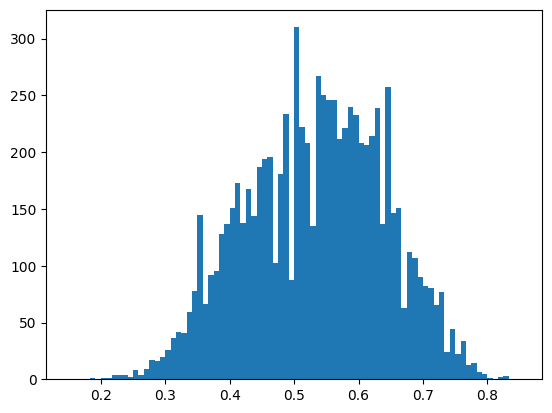

In [7]:
plt.hist(df_odds.implied_prob_h_mid, bins=np.linspace(.15,.85,85));

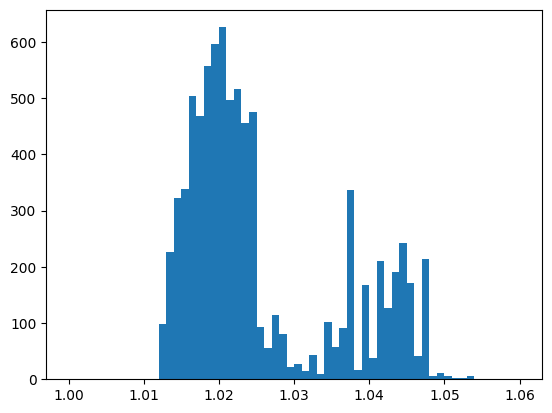

In [8]:
plt.hist(df_odds.implied_prob_h + df_odds.implied_prob_v, bins=np.linspace(1,1.06,61));

# interesting to see second peak around 1.04-1.05 ... IDEAS??

In [9]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1901) & (df.season<=2000)]
df_valid = df[(df.season>=2001) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [10]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            # 'OBP_30_h','OBP_30_v',
            # 'SLG_30_h','SLG_30_v',
            # 'game_no_h',
           ]
target = 'home_victory'

In [11]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()
X_train.shape, X_valid.shape, X_test.shape, 

((151712, 4), (47052, 4), (4856, 4))

In [12]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=3)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 82137, number of negative: 69575
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 151712, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541401 -> initscore=0.165983
[LightGBM] [Info] Start training from score 0.165983
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689215
[20]	valid_0's binary_logloss: 0.688535
[30]	valid_0's binary_logloss: 0.687953
[40]	valid_0's binary_logloss: 0.687555
[50]	valid_0's binary_logloss: 0.687239
[60]	valid_0's binary_logloss: 0.686996
[70]	valid_0's binary_logloss: 0.686813
[80]	valid_0's binary_logloss: 0.686655
[90]	valid_0's binary_logloss: 0.686527
[100]	valid_0's binary_logloss: 0.686447
[110]	valid_0's binary_logloss: 0.686362
[1

LGBMClassifier(learning_rate=0.02, max_depth=3, n_estimators=1000)

In [13]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [14]:
hv_mean = y_train.mean()

In [15]:
lgbm_loss = log_loss(y_test, preds_lgbm)
naive_loss = log_loss(y_test, hv_mean*np.ones(len(y_test)))
lgbm_loss, naive_loss

(0.684486783906771, 0.6905369911423601)

In [16]:
lv_loss = log_loss(y_test, df_test.implied_prob_h_mid)
lv_loss

0.6674197609198098

In [17]:
(naive_loss - lgbm_loss)/(naive_loss - lv_loss)

0.26171851806395485

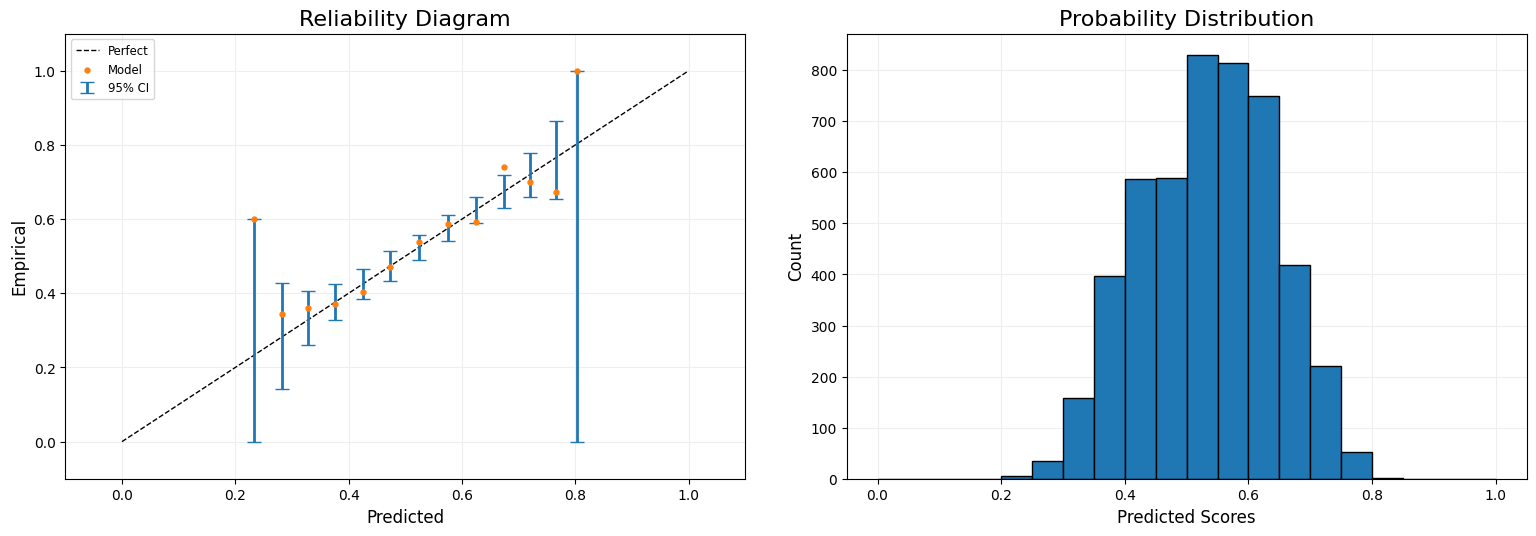

In [18]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, df_test.implied_prob_h_mid, show_histogram=True);

In [19]:
test_disc = np.abs(preds_lgbm - df_test.implied_prob_h_mid)

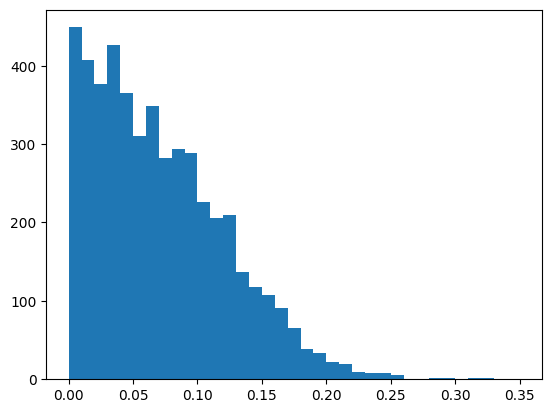

In [20]:
plt.hist(test_disc, np.linspace(0,.35,36));

In [21]:
df_test[test_disc>0.25]

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result
204012,20220614,0,Tue,ATL,NL,63,WAS,NL,64,10,4,54,N,NaN,NaN,NaN,WAS11,24490.0,194.0,115002001,003001000,39.0,13.0,1.0,0.0,5.0,9.0,0.0,1.0,1.0,4.0,0.0,8.0,0.0,0.0,0.0,0.0,8.0,3.0,4.0,4.0,1.0,0.0,27.0,7.0,0.0,0.0,0.0,0.0,33.0,7.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,4.0,4.0,10.0,10.0,1.0,0.0,27.0,6.0,0.0,0.0,0.0,0.0,wolcq901,Quinn Wolcott,porta901,Alan Porter,dejer901,Ramon De Jesus,becka901,Adam Beck,NaN,(none),NaN,(none),snitb801,Brian Snitker,martd002,Dave Martinez,friem001,Max Fried,tetrj001,Jackson Tetreault,stepj002,Jackson Stephens,swand001,Dansby Swanson,friem001,Max Fried,tetrj001,Jackson Tetreault,acunr001,Ronald Acuna,9,swand001,Dansby Swanson,6,rilea001,Austin Riley,5,olsom001,Matt Olson,3,darnt001,Travis d'Arnaud,2,ozunm001,Marcell Ozuna,10,duvaa001,Adam Duvall,7,arcio002,Orlando Arcia,4,harrm004,Michael Harris,8,thoml002,Lane Thomas,9,hernc005,Cesar Hernandez,4,cruzn002,Nelson Cruz,10,bellj005,Josh Bell,3,franm004,Maikel Franco,5,garcl006,Luis Garcia,6,adamr004,Riley Adams,2,adrie001,Ehire Adrianza,7,roblv001,Victor Robles,8,NaN,Y,2022,-6,0,14,202206140,0.263332,0.247158,0.333996,0.312458,0.416712,0.437844,0.750709,0.750302,56.0,65.0,22.0,21.0,106.0,62.0,0.263362,0.263810,0.326222,0.316534,0.397473,0.474286,0.723695,0.790820,16.0,15.0,5.0,9.0,17.0,15.0,0.294118,0.736842,0.278638,9.0,O
204625,20220801,0,Mon,NYN,NL,102,WAS,NL,104,7,3,54,N,NaN,NaN,NaN,WAS11,29034.0,200.0,031003000,100200000,37.0,13.0,2.0,0.0,2.0,7.0,0.0,0.0,2.0,3.0,0.0,7.0,0.0,0.0,2.0,0.0,8.0,3.0,2.0,2.0,0.0,0.0,27.0,5.0,1.0,0.0,0.0,0.0,33.0,6.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,3.0,0.0,6.0,1.0,0.0,0.0,0.0,6.0,6.0,7.0,7.0,0.0,0.0,27.0,13.0,0.0,0.0,2.0,0.0,vanol901,Larry Vanover,rackd901,David Rackley,barbs901,Sean Barber,riggj901,Jeremy Riggs,NaN,(none),NaN,(none),showb801,Buck Showalter,martd002,Dave Martinez,schem001,Max Scherzer,corbp001,Patrick Corbin,NaN,(none),nidot001,Tomas Nido,schem001,Max 

In [22]:
# 'Fancy' code that basically says, if the home team is favored then take select their SP. If not, select the oppo SP.

# These are the pitchers that were favored in these games
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']>.5 
 else row[1]['pitcher_start_name_v'] 
 for row in df_test[test_disc>.25].iterrows() ]

['Max Fried',
 'Max Scherzer',
 'Jacob deGrom',
 'Chris Bassitt',
 'Mike Clevinger',
 'Yu Darvish',
 'Blake Snell',
 'Yu Darvish',
 'Spencer Strider',
 'Sandy Alcantara']

In [23]:
# These are the underdog pitchers in these games
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']<.5 
 else row[1]['pitcher_start_name_v'] for row in df_test[test_disc>.25].iterrows() ]

['Jackson Tetreault',
 'Patrick Corbin',
 'Cory Abbott',
 'Anibal Sanchez',
 'Cory Abbott',
 'Anibal Sanchez',
 'Paolo Espino',
 'Anibal Sanchez',
 'Chad Kuhl',
 'Anibal Sanchez']

In [24]:
pd.crosstab(df_test.home_victory[test_disc>.2], 
            np.round(df_test.implied_prob_h_mid[test_disc>.2], decimals=1))

implied_prob_h_mid,0.2,0.3,0.4,0.7,0.8
home_victory,,,,,
0,2,25,4,2,5
1,2,6,4,18,8


In [25]:
pd.crosstab(df_test.home_victory[test_disc>.2], 
            np.round(preds_lgbm[test_disc>.2], decimals=1))

col_0,0.4,0.5,0.6
home_victory,,,
0,0,28,10
1,1,27,10


Analysis 

- LV odds are "better" than our current model
- Largest discrepancies appear when we have a strong pitcher vs a weak pitcher
- LV probs seem to be "right" in those cases

CONCLUSION: Need to factor in the starting pitcher to improve our model!